# **Q1**

# **Analysis of the Problem** 

I am trying to classify snakes and dangerous animals against less harmful animals by looking at images. There are 15 animal(and reptile) species in the dataset, out of which 6 species are dangerous to human lives. These are snakes, black bears, cougars, elks, gray wolves and coyotes. 

**Why am I doing this?**

With the cutting down of forests, different species of animals are entering villages and towns that are close to their habitat. This is causing a huge disruption to humans living in those areas, and sometimes they are also resulting in fatalities. These happens when the animals enter the homes, shops, etc. completely unnoticed, especially snakes. If a mechanism can be setup which detects the animals, it will be really helpful. There is around 130,000 deaths every year from snake bites and three times more ampputations every year. This has been increasing gradually over the last few years. This is going to increase even more with destruction of their habitat. Moreover, coyotes, cougars and elks are very dangerous. Sometimes their attacks can result in casualties. Black bears and gray wolves  are also known to attack humans. Most of them are not so dangerous, when they live in the wild. But due to above mentioned reasons, they can sometimes enter human population and cause chaos. Not just attacks, these animals spread diseases when they come into their households. For e.g.raccoon faeces cause infections. As a result, it is important to track their entry into townships or even into houses near the forests. Cameras fit into places, can alarm the people concerned. For this proper classification of these animals are required. This is where deep learning can be used. There is no point in sensing just movements,because deers and cats wont cause any harm. It is of utmost importance to correctly guess the animal or reptile that is approaching.


**Why is this challenging?**

Just classifying between snakes and not snakes would have been easy. But here several animals are considered for which classification wont be easy. For e.g. classifying gray wolf vs gray fox vs red wolf vs coyotes would be very difficult, as they are similar in sizes and colours. Possum and nutria, bobcat and canada-lynx, black-tailed deers ,normal deers and elks are very similar. 
Moreover, within the snake class only, data is from different sources. As a result they are of very different shapes and sizes and colours.
For every animal, images of different postures, different parts like head, tails, feet etc. are used. This will make classification very difficult. From just the image of the face, it is difficult even for humans to tell if it is a possum or a nutria; a bobcat or a canada-lynx. The only difference between a deer and black-tailed deer is the colour of tail. The elk is also very similar, all three of them have antlers.

**Datasets Used**

I have got pictures of the 14 of the species from the oregon wildlife image dataset from kaggle (https://www.kaggle.com/virtualdvid/oregon-wildlife). Around 30% of snake images are from the snake images dataset from kaggle (https://www.kaggle.com/isolatte/snake-images). The rest of the snake images are from AICrowd snake identification challenge dataset (https://www.aicrowd.com/challenges/snake-species-identification-challenge/dataset_files). Note: I think, for viewing the images in AICrowd, one needs to have an account.
I have uploaded all the training data in GitHub. https://github.com/sreyamdasgupta/animals-dataset

In [ ]:
!git clone https://github.com/sreyamdasgupta/animals-dataset.git

Cloning into 'animals-dataset'...
remote: Enumerating objects: 3927, done.
remote: Total 3927 (delta 0), reused 0 (delta 0), pack-reused 3927
Receiving objects: 100% (3927/3927), 1.15 GiB | 44.82 MiB/s, done.
Checking out files: 100% (5250/5250), done.


In [ ]:
import numpy as np
import os
import torch
import torch.nn as nn
import pandas as pd
import torchvision
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.transforms import Normalize,Resize,ToTensor
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import random
import torch.optim as optim
import torch.nn.functional as F
import seaborn as sns
from torchvision import models

use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

import warnings
warnings.filterwarnings('ignore')

# **Q2**

# Data Augmentation and Resizing

I have resized my images to (224,224) shape, which is the default for the two architectures that I have used - AlexNet and VGG.

Data Augmentation is an important task for pre-processing images before they are fed to a CNN model. This creates variations in data. Augmentation tries to capture different shapes, sizes, poses, angles, etc. with having to add more images to an already large dataset. **Augmentaton is done to predict the variances in test data, which may not be available in training data.** Data augmentation also helps in reducing overfitting. For my task, I have used three types of data augmentation - rotation, horizontal flip and translation along the two axes. 

Random Rotation is used to rotate images randomly in the range of -30 to +30 degrees. This is done to create variances in the postures of animals in training data. For e.g. an animal in training data can be looking up, but in the test set, it can be looking down, or vice-versa. For this rotation is applied.

I have flipped my images randomly with a probability of 0.5. I have used only horizontal flipping, and not vertical. Flipping animal images vertically does not make sense. But flipping them horizontally is important. Suppose, in my dataset, most of the images of deers are taken from an angle such that they are moving from left to right. But in the test dataset, a deer can be moving from right to left. Without horizontal flipping, my model wont be able to to pick up on this posture. Thats why horizontal flipping is really important, and I have applied that with a probability of 0.5 (default).

I have also used random affine to translate images along the axes randomly. The translation is done only in the order of 0.1. This helps in repositioning the animal in the picture. Suppose most of the training images have the animals in the centre. Then, my model may fail to correctly predict a test image having an animal in one of the corners. Thats why translation is important.

I have not changed the brightness, or hue, etc. because most of the images were clicked during daytime. Moreover, some of the classes can be differentiated based on colour only (nutria vs possum, gray fox vs red fox, and black-tailed deer vs deer : difference in colour of the tail). 

Finally, I had to normalize using the mean and variance of pixel value. This is used for data whitening, which is expected for images sent as input to the state-of-the-art deep leaning models like resnet, googlenet, vgg, etc. The mean is removed (made 0) and variance is made 1.

In [ ]:
torch.manual_seed(0)
root_dir = "animals-dataset/wildlife"
train_set = ImageFolder(root = os.path.join(root_dir,"Train"),
                        transform = transforms.Compose([
        
        transforms.Resize((224,224)),  #resizing to (224,224) default for alexnet, vgg, etc.
        
        #Data Augmentation
        transforms.RandomRotation(30), #Rotating images to +- 30 degrees
        transforms.RandomHorizontalFlip(), #Default probability is 0.5 . So around 50% of images will be flipped horizontally
        transforms.RandomAffine(0,translate=(0.1,0.1)), #No rotation is done, but the image is moved along the x-axis or y-axis by a factor of 0.2

        transforms.ToTensor(), 

        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])                                
    ]) )
test_set = ImageFolder(root = os.path.join(root_dir,"Test"),
                        transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),    
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
                                 ]                             
     ))
print(train_set, test_set)

Dataset ImageFolder
    Number of datapoints: 3730
    Root location: animals-dataset/wildlife/Train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               RandomRotation(degrees=[-30.0, 30.0], resample=False, expand=False)
               RandomHorizontalFlip(p=0.5)
               RandomAffine(degrees=[0.0, 0.0], translate=(0.1, 0.1))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           ) Dataset ImageFolder
    Number of datapoints: 749
    Root location: animals-dataset/wildlife/Test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


# Class Distribution

The classes are fully balanced. Each class has around 250 images. This will help the model to get the structures relevant to each class. If there was class imbalance, the model will overfit on the class with higher instances.

In [ ]:
print ("Number of classes: ", len(train_set.classes))
distribution = np.asarray(torch.tensor(train_set.targets).bincount())
class_distribution = {}
for i in range(len(train_set.classes)):
  class_distribution[train_set.classes[i]]=distribution[i]
print ("Class distribution: ")
print (class_distribution)

Number of classes:  15
Class distribution: 
{'black_bear': 248, 'bobcat': 248, 'canada_lynx': 248, 'columbian_black-tailed_deer': 250, 'cougar': 246, 'coyote': 250, 'deer': 250, 'elk': 250, 'gray_fox': 250, 'gray_wolf': 250, 'nutria': 246, 'raccoon': 246, 'red_fox': 250, 'snakes': 250, 'virginia_opossum': 248}


# Visualiztion and Analysis of Data Type

I have already discussed a few challenges related to prediction using this dataset, and it is clearly evidenced during visualization. I have talked about how it will be difficult to predict one out of gray wolf, gray fox, red fox or coyote. This is clear from the images. It will be difficult even for humans to predict the gray fox. Most gray foxes have red colour round their neck. The only difference with red fox is that the former has gray colour on the rear side. On the other hand, coyotes and gray wolves are also very similar.

Moreover, the two types of deers and the elk are very similar. The deers are almost same, with the former just having a black tail. As a result, it is almost impossible to guess the black-tailed deer without looking at its tail.

The bobcat and canada lynx are two types of cat that are very similar. It is also very difficult to differentiate between them.

The possums and nutrias are also similar in shapes and sizes. But their colours are different. This can be used to differentiate between them.  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

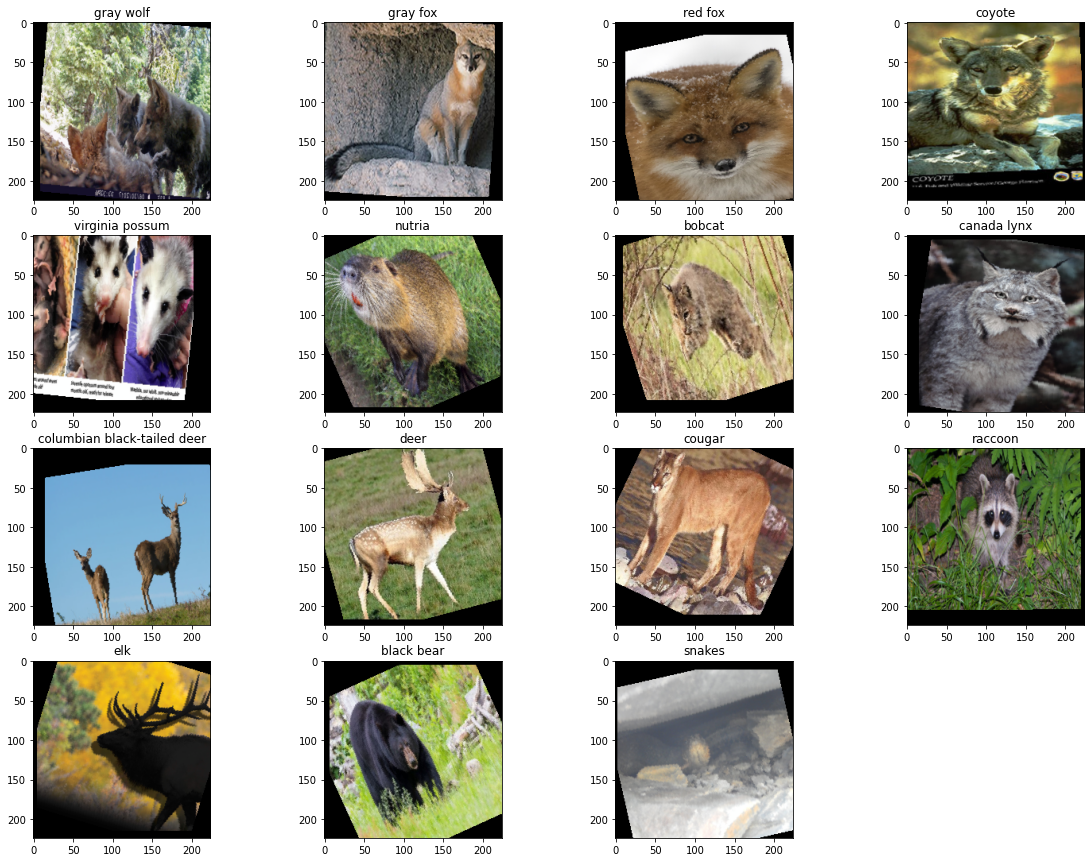

In [ ]:
torch.manual_seed(7)
loader = torch.utils.data.DataLoader(train_set,batch_size = 1, shuffle = True)
corresponding_labels = {b:a for a,b in train_set.class_to_idx.items()}
image_dict = {}
mean=np.array([0.485, 0.456, 0.406])
std=np.array([0.229, 0.224, 0.225])
for i in range(100):
  image,label = next(iter(loader))
  image = image.numpy().squeeze().transpose(1,2,0)
  image = std*image + mean
  image_dict[corresponding_labels[int(label)]] = image
f1 = plt.figure(figsize=(20,15))

ax = f1.add_subplot(441)
ax.imshow(image_dict["gray_wolf"])
ax.title.set_text("gray wolf")

ax2 = f1.add_subplot(442)
ax2.imshow(image_dict["gray_fox"])
ax2.title.set_text("gray fox")

ax3 = f1.add_subplot(443)
ax3.imshow(image_dict["red_fox"])
ax3.title.set_text("red fox")

ax4 = f1.add_subplot(444)
ax4.imshow(image_dict["coyote"])
ax4.title.set_text("coyote")

ax5 = f1.add_subplot(445)
ax5.imshow(image_dict["virginia_opossum"])
ax5.title.set_text("virginia possum")

ax6 = f1.add_subplot(446)
ax6.imshow(image_dict["nutria"])
ax6.title.set_text("nutria")

ax7 = f1.add_subplot(447)
ax7.imshow(image_dict["bobcat"])
ax7.title.set_text("bobcat")

ax8 = f1.add_subplot(448)
ax8.imshow(image_dict["canada_lynx"])
ax8.title.set_text("canada lynx")

ax9 = f1.add_subplot(449)
ax9.imshow(image_dict["columbian_black-tailed_deer"])
ax9.title.set_text("columbian black-tailed deer")

ax10 = f1.add_subplot(4,4,10)
ax10.imshow(image_dict["deer"])
ax10.title.set_text("deer")

ax11 = f1.add_subplot(4,4,11)
ax11.imshow(image_dict["cougar"])
ax11.title.set_text("cougar")

ax12 = f1.add_subplot(4,4,12)
ax12.imshow(image_dict["raccoon"])
ax12.title.set_text("raccoon")

ax13 = f1.add_subplot(4,4,13)
ax13.imshow(image_dict["elk"])
ax13.title.set_text("elk")

ax14 = f1.add_subplot(4,4,14)
ax14.imshow(image_dict["black_bear"])
ax14.title.set_text("black bear")

ax15 = f1.add_subplot(4,4,15)
ax15.imshow(image_dict["snakes"])
ax15.title.set_text("snakes")



# Q3


In [ ]:
#TESTING SET LOOP AND TRAINING LOOP ARE TAKEN (With slight modifications) FROM Week 3 Lab: Convolutional Networks, by Prof. Roderick Murray-Smith

import time
epoch_print_gap = 1

def train_model(model,loader,device):
  loss_func = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(),lr=0.01)
  model = model.to(device)
  for epoch in range (5):
    start = time.time()
    loss = 0
    for batch in loader:
      images,labels = batch
      predictions = model(images.to(device))
      loss_batch = loss_func(predictions, labels.to(device))
      
      optimizer.zero_grad()
      loss_batch.backward()
      optimizer.step()

      loss += loss_batch.item()
    end = time.time()
    print ("Epoch: ", epoch, " Training Loss: ", float(loss)," duration: ", (end-start), " secs")

def test_loop(model, device, test_loader):
    model.eval()
    model = model.to(device)
    test_loss = 0
    correct = 0
    predictions = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            predictions.append(int(pred))
            correct += pred.eq(target.view_as(pred)).sum().item()

    return (predictions,correct/len(test_loader.dataset))

# Baseline Model


The baseline model is a linear model with a relu function attached to it. It receives one image, flattens it out, applies linear transformation, then uses relu on the output.

In [ ]:
class Baseline_Model(nn.Module):
  def __init__(self):
        super(Baseline_Model, self).__init__()
        self.out = nn.Linear(in_features=3*256*256,out_features = 15)
  def forward(self,x):
    x = x.reshape(-1,3*256*256)
    x = self.out(x)
    x = F.relu(x)

    return x
torch.manual_seed(0)
train_loader = torch.utils.data.DataLoader(train_set)
baseline_model = Baseline_Model()
train_model(baseline_model,train_loader,device=device)

Epoch:  0  Training Loss:  125655.97229981422  duration:  98.65885615348816  secs
Epoch:  1  Training Loss:  32133.185007095337  duration:  101.91035079956055  secs
Epoch:  2  Training Loss:  22501.15883255005  duration:  101.60821533203125  secs
Epoch:  3  Training Loss:  32613.559188842773  duration:  100.09431886672974  secs
Epoch:  4  Training Loss:  25617.938499450684  duration:  100.61418890953064  secs


# Pre-Trained Architecture 1

The first architcture that I have chosen is the Alex Net model. This is a ground-breaking model in respect to Deep Learning and CNNs. It was published in 2012. It has five convolutional layers and three fully-connected layers. Its key contributions are: a) usage of ReLu intead of tanh or sigmoid activation functions, and b) using dropout layers to reduce overfitting, c) training on GPUs instead of CPUs, d)data augmentation as a part of preprocessing images

There are several architectures that are trained on the imagenet dataset and can be used for transfer learning. I chose this as one of the two pre-trained architectures because this showed the potential of training large neural net for classification of images.

For my application, I had to change the number of output classes for the last layer. The deafault was 1000. But, I have only 15 classes. So, it has been changed from 1000 to 15.

In [ ]:
torch.manual_seed(0)
train_loader = torch.utils.data.DataLoader(train_set,batch_size = 32)
alex_model = models.alexnet(pretrained=True)
mod1 = alex_model
for param in mod1.parameters():
  param.requires_grad = False
features = mod1.classifier[6].in_features
mod1.classifier[6] = nn.Linear(features,15)
train_model(mod1,train_loader,device=device)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth



Epoch:  0  Training Loss:  98.33627400314435  duration:  96.03776240348816  secs
Epoch:  1  Training Loss:  62.07070367783308  duration:  96.00704979896545  secs
Epoch:  2  Training Loss:  55.68413733690977  duration:  95.5571186542511  secs
Epoch:  3  Training Loss:  47.65219398587942  duration:  94.71284008026123  secs
Epoch:  4  Training Loss:  43.40999749395996  duration:  93.8341383934021  secs


# Pre-Trained Architecture 2

VGG was invented by Visual Geometry Group (Oxford University). They came second in the imagenet competition after google net. This model has important contributions towards deep learning. They proved that performance can be improved by using small receptive fields instead of larger ones. This will reduce the number of parameters. This does not reduce the effectiveness, but increases the efficiency significantly. So, I selected this over other networks

For my application, I had to change the number of output classes for the last layer. The deafault was 1000. But, I have only 15 classes. So, it has been changed from 1000 to 15.

In [ ]:
torch.manual_seed(0)
vgg_model = models.vgg16(pretrained=True)
mod2 = vgg_model #Going to use mod2 for basic comparison. vgg_model will later be used for proper training with cross-validation in question 4
for param in mod2.parameters():
  param.requires_grad = False
features = mod2.classifier[6].in_features
mod2.classifier[6] = nn.Linear(features,15)
train_loader = torch.utils.data.DataLoader(train_set)
train_model(mod2,train_loader,device=device)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth



Epoch:  0  Training Loss:  248.04383495259236  duration:  151.295880317688  secs


KeyboardInterrupt: ignored

# Other architectures considered

I have also considered vgg11. But vgg16 performed better. So, I chose that. I also considered resnet16, resnet50 and google net. But, they performed very poorly (based on training loss). So, I chose vgg16 and alexnet for final comparison. 

In [ ]:
torch.manual_seed(0)
resnet_model = models.resnet18(pretrained=True)
for param in resnet_model.parameters():
  param.requires_grad = False
features = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(features,15)
train_model(resnet_model,train_loader,device=device)

Epoch:  0  Training Loss:  111.88534860312939  duration:  98.42915558815002  secs
Epoch:  1  Training Loss:  118.97949045524001  duration:  98.56878972053528  secs
Epoch:  2  Training Loss:  118.46191333979368  duration:  98.25258588790894  secs
Epoch:  3  Training Loss:  117.79665564745665  duration:  98.21338319778442  secs
Epoch:  4  Training Loss:  117.00867739319801  duration:  98.13989758491516  secs


In [ ]:
torch.manual_seed(0)
googlenet_model = models.googlenet(pretrained=True)
for param in googlenet_model.parameters():
  param.requires_grad = False
features = googlenet_model.fc.in_features
googlenet_model.fc = nn.Linear(features,15)
train_model(googlenet_model,train_loader,device=device)

Epoch:  0  Training Loss:  183.10910892486572  duration:  99.50042176246643  secs
Epoch:  1  Training Loss:  197.45973113179207  duration:  99.56480360031128  secs
Epoch:  2  Training Loss:  198.1275354474783  duration:  99.92978239059448  secs
Epoch:  3  Training Loss:  197.56757067143917  duration:  99.3737199306488  secs
Epoch:  4  Training Loss:  197.68081592023373  duration:  99.30438089370728  secs


# Comparison between the three

The VGG model trained so far has the highest accuracy on test data set. So, I am going to use that for training. Alex Net model also performs well. But, the baseline model performs very poorly. This is expected because the baseline model is just a simple model with one linear layer, and a relu function. Around 9 of the classes are being correctly predicted by VGG, around 7 by alexnet and none of the classes are being correctly predicted by the linear model. 

In [ ]:
test_loader = torch.utils.data.DataLoader(test_set)
y_test = np.array([y for x, y in iter(test_set)])
base_pred,base_acc = test_loop(model = baseline_model, device = device, test_loader = test_loader)
alex_pred,alex_acc = test_loop(model = mod1, device = device, test_loader = test_loader)
vgg_pred,vgg_acc = test_loop(model = mod2, device = device, test_loader = test_loader)
print ("Accuracy: Baseline Model = %.2f, Alexnet Model = %.2f, VGG Model = %.2f" %(100*base_acc,100*alex_acc,100*vgg_acc))
print ("Confusion Matrix for baseline model: \n",confusion_matrix(y_test,base_pred))
print ("Confusion Matrix for alexnet model: \n",confusion_matrix(y_test,alex_pred))
print ("Confusion Matrix for vgg model: \n",confusion_matrix(y_test,vgg_pred))

Accuracy: Baseline Model = 6.94, Alexnet Model = 57.14, VGG Model = 69.29
Confusion Matrix for baseline model: 
 [[10  0  9 20  0  0  0  4  2  0  3  1  1  0  0]
 [19  1  4  4  1  2  0 13  1  1  3  0  0  0  1]
 [12  0  9  1  0  4  1 11  0  4  1  1  1  0  5]
 [10  0 13  3  2  0  0 15  0  1  3  0  2  1  0]
 [10  2  5  3  4  2  0 15  1  1  2  0  0  0  5]
 [16  0  5  1  0  4  0 16  0  0  3  1  0  0  4]
 [15  0  4  4  0  2  0 15  0  0  3  1  4  1  1]
 [15  1  4  2  2  1  0 12  1  3  2  1  3  0  3]
 [13  0  4  4  1  3  0 11  0  2  1  3  1  0  7]
 [ 6  0  5  4  1  3  1 16  1  2  2  1  2  0  6]
 [17  0  1 10  1  1  0 15  0  0  3  1  0  0  0]
 [14  1  3  5  0  1  0 18  0  2  3  2  1  0  0]
 [15  3  6  1  0  7  1 12  1  1  1  0  0  0  2]
 [10  0  4  7  2  5  0 11  2  2  4  0  2  0  1]
 [ 9  2  2  1  3  2  1 17  0  2  4  1  2  2  2]]
Confusion Matrix for alexnet model: 
 [[39  0  0  0  0  0  0  2  0  0  2  1  3  2  1]
 [ 0  9  7  0  0  1  6  0  1  8  1  4  7  5  1]
 [ 0  0 19  0  1  0  1  1  0 18 

# Q4

I have used the python library skorch for this task. They help us apply scikit-learn tools on pytorch dataset, thus the name skorch. 

In [ ]:
!pip install skorch

     |████████████████████████████████| 133kB 9.1MB/s 


I have frozen all the layers except for the last two layers. My dataset is small, and it is similar to the imagenet dataset that the vgg model has previously trained on. So, I am not trying to tune the weights in the convolutional part. I have unfrozen the last two layers of my model. 

In [ ]:
import skorch
from skorch import NeuralNetClassifier
from skorch.dataset import CVSplit
from skorch.helper import SliceDataset
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from skorch.callbacks import EarlyStopping

#Freezing all layers, except for the last two in vgg11 model
for param in vgg_model.parameters():
  param.requires_grad = False
features1 = vgg_model.classifier[3].in_features
vgg_model.classifier[3] = nn.Linear(features1,1000)
vgg_model.classifier[6] = nn.Linear(1000,15)


vgg_mod = NeuralNetClassifier(
    vgg_model,
    optimizer = optim.SGD,
    batch_size = 32,
    criterion=nn.CrossEntropyLoss,
    max_epochs=20,
    device=device,
    train_split = False,
    callbacks = [EarlyStopping(patience=3)]
)

# **Grid Search with 3-fold cross validation** 

The scikit learn function gridsearch cv is being used. I have used 3-fold cross validation. The training set is passed, and the function automatically splits it into temporary training and validation sets. 

I have tuned the parameters sequentially, instead of exhaustive search which would have taken a lot of time.

In [ ]:
train_set_slice = SliceDataset(train_set)
y_train = np.array([y for x, y in iter(train_set)])

I have decided to tune three hyperparameters: optimizer weight decay i.e. the regularization parameter, the learning rate, and the optimizer momentum.

The regularization parameter is really important. It penalizes the weights whose value increases significantly. It helps in reducing overfitting. This parameter should be tuned to find the one that significantly reduces overfitting, by checking the validation accuracy.

The learning rate is very important here. We dont want it to be too small. If it is too small, it will take a lot of epochs to learn the weights - this will waste a lot of time. On the other hand, if it is very high, the loss will overshoot instead of reaching a minima. Moreover, since I am applying transfer learning, if the rate is too high, the pre-determined weights will change very fast. This will have adverse effect on my model.

Finally, the optimizer mommentum determines the acceleration of the loss towards its minima. It helps the optimizer to accelerate towards the minima. 

In [ ]:
params1 =  {'optimizer__weight_decay': [0.00001, 0.0001,0.001]}
params2 =  {'lr': [0.01,0.001]}
params3 = {'optimizer__momentum':[0.95,0.9]}
torch.manual_seed(0)
vgg_mod.initialize();
vgg_gridsearch1 = GridSearchCV(vgg_mod, param_grid=params1, scoring='accuracy', verbose=1, cv=3)
vgg_gridsearch2 = GridSearchCV(vgg_mod, param_grid=params2, scoring='accuracy', verbose=1, cv=3)
vgg_gridsearch3 = GridSearchCV(vgg_mod, param_grid=params3, scoring='accuracy', verbose=1, cv=3)
vgg_gridsearch1.fit(train_set_slice, y_train)
vgg_gridsearch2.fit(train_set_slice, y_train)
vgg_gridsearch3.fit(train_set_slice, y_train)

Re-initializing optimizer.
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Re-initializing optimizer because the following parameters were re-set: weight_decay.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  epoch    train_loss      dur
-------  ------------  -------
      1        1.5915  73.3354
      2        1.3154  73.6740
      3        0.9707  74.1075
      4        0.8094  73.7417
      5        0.7286  73.6819
      6        0.6861  73.7595
      7        0.6422  73.5276
      8        0.6239  73.4699
      9        0.6116  72.3420
     10        0.5911  71.5108
     11        0.5611  70.1171
     12        0.5425  69.4425
     13        0.5368  69.1817
     14        0.5343  70.0878
     15        0.5118  73.4933
     16        0.5053  74.2177
     17        0.4753  74.2921
     18        0.4848  72.1117
     19        0.4876  71.2838
     20        0.4752  70.7902
Re-initializing optimizer because the following parameters were re-set: weight_decay.
  epoch    train_loss      dur
-------  ------------  -------
      1        1.5878  68.1873
      2        1.3192  68.1376
      3        0.9862  67.9572
      4        0.8354  67.6818
      5        0.7384  68.3017
      6        

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 208.1min finished


Re-initializing optimizer because the following parameters were re-set: weight_decay.
  epoch    train_loss      dur
-------  ------------  -------
      1        1.2191  98.8440
      2        0.9784  98.4190
      3        0.7319  98.5253
      4        0.6147  98.5135
      5        0.5556  98.6632
      6        0.5167  99.5250
      7        0.4990  99.4799
      8        0.4857  100.0909
      9        0.4661  99.8032
     10        0.4406  100.1868
     11        0.4326  101.7196
     12        0.4330  102.6454
     13        0.4274  102.6583
     14        0.4158  100.2496
     15        0.3980  100.9079
     16        0.3957  100.2381
     17        0.4032  100.3436
     18        0.3995  102.5328
Stopping since train_loss has not improved in the last 3 epochs.
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Re-initializing optimizer.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  epoch    train_loss      dur
-------  ------------  -------
      1        1.5726  68.4559
      2        1.2993  73.5582
      3        0.9724  77.4092
      4        0.8192  73.3618
      5        0.7391  68.5736
      6        0.6807  67.9783
      7        0.6597  67.5747
      8        0.6428  67.4954
      9        0.6057  67.3518
     10        0.5830  69.2832
     11        0.5700  67.7755
     12        0.5478  68.7853
     13        0.5224  68.9293
     14        0.5234  69.4767
     15        0.5219  68.4761
     16        0.5228  67.5155
     17        0.4899  67.2866
     18        0.4979  67.7218
     19        0.4881  67.1790
     20        0.4861  67.8012
Re-initializing optimizer.
  epoch    train_loss      dur
-------  ------------  -------
      1        1.5984  65.8771
      2        1.3083  65.8466
      3        0.9849  65.7434
      4        0.8201  66.3222
      5        0.7240  66.5841
      6        0.6767  65.8233
      7        0.6524  65.6782
      8     

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 135.2min finished


Re-initializing optimizer.
  epoch    train_loss      dur
-------  ------------  -------
      1        2.5632  97.8672
      2        2.2675  98.1566
      3        2.0092  98.2375
      4        1.7651  98.1907
      5        1.5935  98.2811
      6        1.4124  97.9080
      7        1.2945  97.8528
      8        1.1943  99.0192
      9        1.1346  98.2595
     10        1.0806  98.5364
     11        1.0177  98.4539
     12        0.9636  98.2006
     13        0.9330  97.9199
     14        0.9016  98.0687
     15        0.8814  98.3287
     16        0.8394  98.3741
     17        0.8250  97.8663
     18        0.8033  98.2900
     19        0.8008  97.9043
     20        0.7627  97.7317
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Re-initializing optimizer because the following parameters were re-set: momentum.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  epoch    train_loss      dur
-------  ------------  -------
      1        2.9341  66.7141
      2        3.1055  66.4240
      3        3.0057  66.4252
Stopping since train_loss has not improved in the last 3 epochs.
Re-initializing optimizer because the following parameters were re-set: momentum.
  epoch    train_loss      dur
-------  ------------  -------
      1        2.9983  64.8942
      2        3.0025  64.8225
      3        2.9406  64.7770


KeyboardInterrupt: ignored

In [ ]:
print ("The best parameters for vgg model: ", vgg_gridsearch1.best_params_,vgg_gridsearch2.best_params_)

The best parameters for vgg model:  {'optimizer__weight_decay': 0.0001} {'lr': 0.001}


Due to early_stopping, the model was stopped while checking for optimizer momentum. So, I am going to restart grid search for optimizer momentum without the early stopping call back.

In [ ]:
vgg_mod = NeuralNetClassifier(
    vgg_model,
    optimizer = optim.SGD,
    batch_size = 32,
    criterion=nn.CrossEntropyLoss,
    max_epochs=20,
    device=device,
    train_split = False
)

params3 = {'optimizer__momentum':[0.9,0.8,0.7]}
torch.manual_seed(0)
vgg_mod.initialize();
vgg_gridsearch3 = GridSearchCV(vgg_mod, param_grid=params3, scoring='accuracy', verbose=1, cv=3,refit = False)
vgg_gridsearch3.fit(train_set_slice, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Re-initializing optimizer because the following parameters were re-set: momentum.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  epoch    train_loss      dur
-------  ------------  -------
      1        2.8472  97.7799
      2        2.7738  94.1419
      3        2.6814  96.0652
      4        2.5577  90.3388
      5        2.6454  91.7513
      6        2.7787  90.5963
      7        2.8186  92.4114
      8        2.7495  89.5320
      9        2.4599  88.4090
     10        2.4240  91.0340
     11        2.4157  87.9288
     12        2.4427  89.8795
     13        2.3380  88.7063
     14        2.1576  93.4053
     15        2.2611  88.3201
     16        2.2465  88.6027
     17        2.1940  88.3498
     18        2.0392  88.5560
     19        2.1099  88.2746
     20        2.1316  88.5270
Re-initializing optimizer because the following parameters were re-set: momentum.
  epoch    train_loss      dur
-------  ------------  -------
      1        2.8959  85.9232
      2        2.8963  85.9835
      3        2.7146  86.2946
      4        2.7115  86.6048
      5        2.5810  87.9500
      6        2.42

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 269.3min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), paddin...
      (2): Dropout(p=0.5, inplace=False)
      (3): Linear(in_features=4096, out_features=1000, bias=True)
      (4): ReLU(inplace=True)
      (5): Dropout(p=0.5, inplace=False)
      (6): Linear(in_features=1000, out_features=15, bias=True)
    )
  ),
),
             iid='deprecated', n_jobs=None,
             param_grid={'optimizer__momentum': [0.9, 0.8, 0.7]},
             pre_dispatch='2*n_jobs', refit=False, return_train_score=False,
             scoring='accuracy', verbose=1)

In [ ]:
print ("The best optimizer momentum for vgg model: ", vgg_gridsearch3.best_params_)

The best optimizer momentum for vgg model:  {'optimizer__momentum': 0.7}


The best values for hyperparameters are:

Optimizer Momentum : 0.7

Learning Rate : 0.001

Optimizer weight decay : 0.0001

I am now going to train my model using the best values obtained from tuning. I am going to use early stopping on validation loss. But I will keep a patience of 5 i.e. if validation loss does not decrease for 5 consecutive steps, then only it will stop. I am using this to reduce overfitting. Once validation loss starts increasing step by step, it can be assumed that training has been completed, and now the model may start overfitting on train data. 

To reduce overfitting, L2 regularization parameter has been used. This is important, as deep learning models tend to overfit on train set without any regularization.

In [ ]:
torch.manual_seed(0)
#Using the best parameters obtained from grid search
#Training for 50 epochs
vgg_mod = NeuralNetClassifier(
    vgg_model,
    optimizer__weight_decay = 0.0001,
    lr = 0.001,
    optimizer = optim.SGD,
    optimizer__momentum = 0.7,
    batch_size = 32,
    criterion=nn.CrossEntropyLoss,
    max_epochs=50,
    device=device,
    callbacks = [EarlyStopping(monitor="valid_loss",patience=5)]
)
vgg_mod.fit(train_set,y=y_train)

  epoch    train_loss    valid_acc    valid_loss       dur
-------  ------------  -----------  ------------  --------
      1        2.6666       0.4223        2.1366  151.3701
      2        2.0906       0.5161        1.6885  152.0380
      3        1.6585       0.5952        1.3836  150.7955
      4        1.3954       0.6260        1.1957  150.8314
      5        1.2349       0.6649        1.0844  153.6682
      6        1.1175       0.6823        0.9941  152.4651
      7        1.0384       0.7091        0.9224  152.4709
      8        0.9745       0.7064        0.8783  150.4810
      9        0.9562       0.7346        0.8312  150.4461
     10        0.8963       0.7319        0.8322  151.2200
     11        0.8763       0.7426        0.7692  151.4463
     12        0.8307       0.7453        0.7687  148.9003
     13        0.8251       0.7574        0.7470  148.2941
     14        0.7927       0.7560        0.7253  147.5488
     15        0.7704       0.7775        0.6980  151.34

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding

# Q5

# Visualization of training performance

The model has not overfit on training. The validation loss has gradually decreased. It almost become a plateau after 35 epochs, but it did not start increasing, thanks to regularization. The validation set accuracy has increased significantly for the first 15 epochs. After that it has increased slowly over time. After 15 epochs, validation accuracy was 77%, and it gradually increased to 83% after 50 epochs.

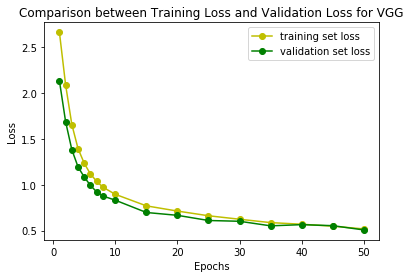

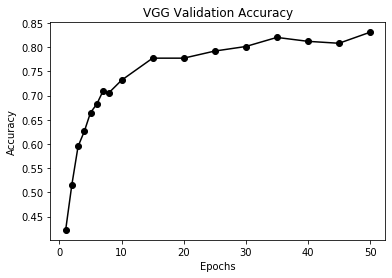

In [ ]:
epoch_list = [1,2,3,4,5,6,7,8,10,15,20,25,30,35,40,45,50]
train_loss_vgg = [2.6666,2.0906,1.6585,1.3954,1.2349,1.1175,1.0384,0.9745,0.8963,0.7704,0.7135,0.6623,0.6244,0.5875,0.5698,0.5483,0.5186]
validation_loss_vgg = [2.1366,1.6885,1.3836,1.1957,1.0844,0.9941,0.9224,0.8783,0.8322,0.6980,0.6670,0.6106,0.6021,0.5522,0.5652,0.5540,0.5077]
plt.figure(3)
plt.title("Comparison between Training Loss and Validation Loss for VGG")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(epoch_list,train_loss_vgg,'yo-',label="training set loss")
plt.plot(epoch_list,validation_loss_vgg,'go-',label="validation set loss")
plt.legend()
val_accuracy_vgg = [0.4223,0.5161,0.5952,0.6260,0.6649,0.6823,0.7091,0.7064,0.7319,0.7775,0.7775,0.7922,0.8016,0.8204,0.8123,0.8083,0.8311]
plt.figure(4)
plt.title("VGG Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(epoch_list,val_accuracy_vgg,"ko-")

# Checking on Test Set

The accuaracy of 81.5 on test set is satisfactory (according to me), given the challenges in the dataset. Checking the confusion matrix will tell us more about what the model has done correctly, and where it has failed.

In [ ]:
vgg_predictions = vgg_mod.predict(test_set)
vgg_accuracy = accuracy_score(y_test,vgg_predictions)
print ("Accuracy for vgg: ",100*vgg_accuracy)

Accuracy for vgg:  85.04672897196261


[[0, 'black_bear'], [1, 'bobcat'], [2, 'canada_lynx'], [3, 'columbian_black-tailed_deer'], [4, 'cougar'], [5, 'coyote'], [6, 'deer'], [7, 'elk']]
[[8, 'gray_fox'], [9, 'gray_wolf'], [10, 'nutria'], [11, 'raccoon'], [12, 'red_fox'], [13, 'snakes'], [14, 'virginia_opossum']]


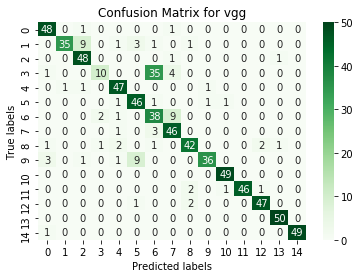

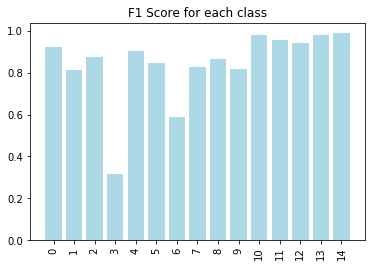

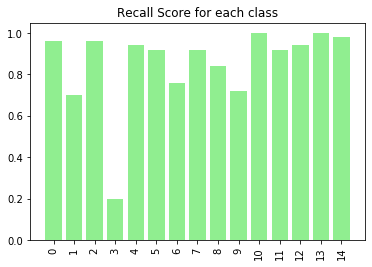

In [ ]:
class_list = [[v,k] for k,v in train_set.class_to_idx.items()]
vgg_cm = confusion_matrix(y_test,vgg_predictions)

x = list(set(train_set.targets))
plt.figure(10)
ax= plt.subplot()
sns.heatmap(vgg_cm, annot=True, ax = ax,cmap="Greens");
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix for vgg'); 
ax.xaxis.set_ticklabels(x); ax.yaxis.set_ticklabels(x);
plt.figure(15)
plt.bar(x,f1_score(y_test,vgg_predictions,average=None),color = "lightblue")
plt.xticks(x,rotation="vertical")
plt.title("F1 Score for each class")
plt.figure(16)
plt.bar(x,recall_score(y_test,vgg_predictions,average=None),color = "lightgreen")
plt.title("Recall Score for each class")
plt.xticks(x,rotation="vertical")
print (class_list[:8])
print (class_list[8:])

# Checking misclassified images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


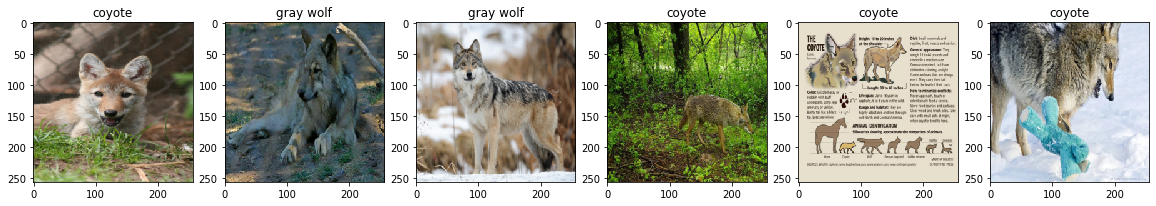

In [ ]:
torch.manual_seed(0)
loader = torch.utils.data.DataLoader(test_set,batch_size = 1, shuffle = True)
mean=np.array([0.485, 0.456, 0.406])
std=np.array([0.229, 0.224, 0.225])
count = 0
f1 = plt.figure(figsize=(20,6))
for i in range(100):
  if (count==6):
    break
  image,label = next(iter(loader))
  if (label == 5 or label == 9):
    count += 1
    image = image.numpy().squeeze().transpose(1,2,0)
    image = std*image + mean
    ax = f1.add_subplot(1,6,count)
    ax.imshow(image)
    if (label==9):
      ax.title.set_text("gray wolf")
    if (label==5):
      ax.title.set_text("coyote")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


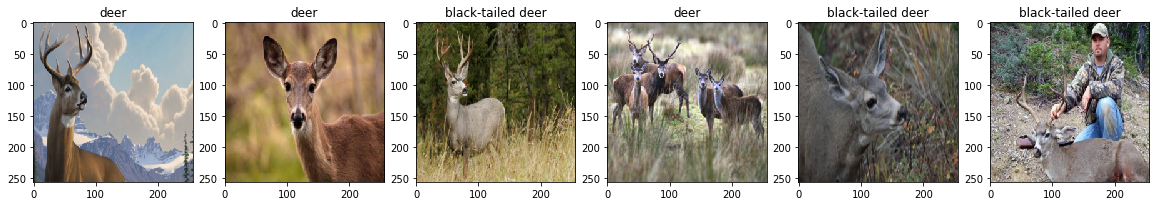

In [ ]:
torch.manual_seed(2)
count = 0
f2 = plt.figure(figsize=(20,6))
for i in range(100):
  if (count==6):
    break
  image,label = next(iter(loader))
  if (label == 3 or label == 6):
    count += 1
    image = image.numpy().squeeze().transpose(1,2,0)
    image = std*image + mean
    ax = f2.add_subplot(1,6,count)
    ax.imshow(image)
    if (label==3):
      ax.title.set_text("black-tailed deer")
    if (label==6):
      ax.title.set_text("deer")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


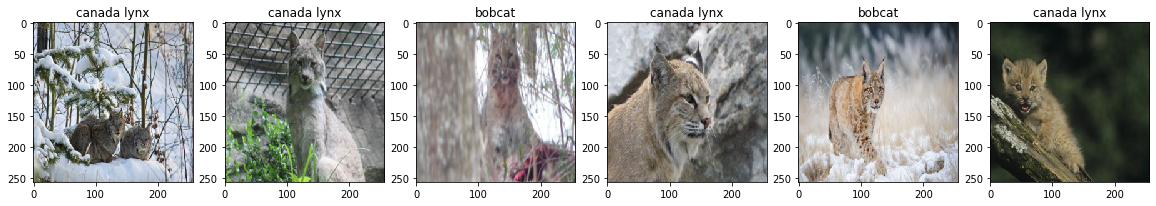

In [ ]:
torch.manual_seed(0)
count = 0 
f3 = plt.figure(figsize=(20,6))
for i in range(100):
  if (count==6):
    break
  image,label = next(iter(loader))
  if (label == 1 or label == 2):
    count += 1
    image = image.numpy().squeeze().transpose(1,2,0)
    image = std*image + mean
    ax = f3.add_subplot(1,6,count)
    ax.imshow(image)
    if (label==1):
      ax.title.set_text("bobcat")
    if (label==2):
      ax.title.set_text("canada lynx")

## **Q6** 

# **Report**

VGG16 has proved to be the better model for classification on this dataset. It has given a good enough accuracy on the test set. My main aim was to classify the dangerous animals (and snakes). Out of the 15 classes, snakes, black bears, cougars, gray wolves, elks and coyotes are considered to be dangerous. Snakes are the most dangerous, and they often (compared to others) enter the household unnoticed. For this reason, it is important to classify them correctly. This will help people living near forests, and even wildlife photographers who can be unaware of the dangers lying ahead. The data is gathered from three different places, and modified to satisfy our requirements (and also keep it challenging enough). I have used 250 images (approx) for each class to maintain class balance. A few of the classes are very similar to each other like deer, black-tailed deer and elks; red fox and gray fox; gray wolf and coyote; bobcat and canada lynx.



Firstly, the images have been resized to (224,224) which is the default for resnet, alexnet, vgg, etc. Next, data augmentation is applied to increase variance in train set that could have been absent otherwise. This helps in reducing overfitting (a key contribution of alexnet). Different techniques like rotation, horizontal flipping, and translation have been used. Random Rotation is used to rotate images randomly in the range of -30 to +30 degrees. This is done to create variances in the postures of animals in training data. For e.g. an animal in training data can be looking up, but in the test set, it can be looking down, or vice-versa. For this rotation is applied. I have flipped my images randomly with a probability of 0.5. I have used only horizontal flipping, and not vertical. Flipping animal images vertically does not make sense. But flipping them horizontally is important. Suppose, in my dataset, most of the images of deers are taken from an angle such that they are moving from left to right. But in the test dataset, a deer can be moving from right to left. Without horizontal flipping, my model wont be able to to pick up on this posture. Thats why horizontal flipping is really important, and I have applied that with a probability of 0.5 (default). I have also used random affine to translate images along the axes randomly. The translation is done only in the order of 0.1. This helps in repositioning the animal in the picture. Suppose most of the training images have the animals in the centre. Then, my model may fail to correctly predict a test image having an animal in one of the corners. Thats why translation is important. Next data whitening is applied to prepare the images to pass to the model.

A baseline model is created with just one linear layer. It fails miserably because it has no convolutional layer. Only one layer is connecting all the neurons to the output classes. Four state-of-the-art architectures are considered and trained for 5 epochs. Based on the convergence of training loss, only two are used for testing on the dataset. These are alexnet and vgg. Alexnet was one of the first state-of-the-art models, and was the winner of the first imagenet competition. It had several key contributions: a) usage of ReLu intead of tanh or sigmoid activation functions, and b) using dropout layers to reduce overfitting, c) training on GPUs instead of CPUs, d)data augmentation as a part of preprocessing images. The second model I chose was VGG

In [ ]:
vgg_predictions = vgg_mod.predict(test_set)
vgg_accuracy = accuracy_score(y_test,vgg_predictions)
print ("Accuracy for vgg: ",100*vgg_accuracy)

Accuracy for vgg:  85.04672897196261


Let us check how the model has fared for all the classes. A classification report will help us to understand this.

[[0, 'black_bear'], [1, 'bobcat'], [2, 'canada_lynx'], [3, 'columbian_black-tailed_deer'], [4, 'cougar'], [5, 'coyote'], [6, 'deer'], [7, 'elk']]
[[8, 'gray_fox'], [9, 'gray_wolf'], [10, 'nutria'], [11, 'raccoon'], [12, 'red_fox'], [13, 'snakes'], [14, 'virginia_opossum']]
Classification Report for vgg: 
               precision    recall  f1-score   support

           0       0.89      0.96      0.92        50
           1       0.97      0.70      0.81        50
           2       0.80      0.96      0.87        50
           3       0.77      0.20      0.32        50
           4       0.87      0.94      0.90        50
           5       0.78      0.92      0.84        50
           6       0.48      0.76      0.59        50
           7       0.75      0.92      0.83        50
           8       0.89      0.84      0.87        50
           9       0.95      0.72      0.82        50
          10       0.96      1.00      0.98        49
          11       1.00      0.92      0.96 

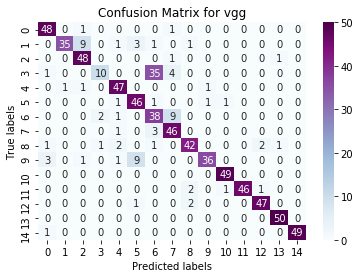

In [ ]:
print (class_list[:8])
print (class_list[8:])
print ("Classification Report for vgg: \n",classification_report(y_test,vgg_predictions))
plt.figure(11)
ax= plt.subplot()
sns.heatmap(vgg_cm, annot=True, ax = ax,cmap="BuPu");
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix for vgg'); 
ax.xaxis.set_ticklabels(x); ax.yaxis.set_ticklabels(x);

Let us check how the model has fared for all the classes. A classification report will help us to understand this. Let us first check if my model can classify the dangerous animals correctly.

The most dangerous of them is snakes. All of the snakes are classified correctly. It has a recall of 1. Black bears are classified with a recall of 0.96, elk with a recall of 0.98, cougars with 0.96, gray wolves with 0.88. These are being classified reasonably well. But coyotes have a recall of just 0.32. From the confusion matrix, it is evident that most of them are being classified as gray wolves, and some as gray foxes. This is happening, because their colours are similar and their stature is also similar. As a result, the model is being unable to classify the coyotes properly. This is a cause of concern.

I used recall because we definitely want to be alarmed if a dangerous animal is nearby. But at the same time, we dont want to get a false alarm, when no dangerous animal is near us. Now let us consider the precision at which each of them are being classified. Snake is being classified with a precision of 0.93, black bears with 0.92, cougars with 0.92. Coyotes have a high precision because they are not getting classified in the first place. Most of them are being classified as gray wolves. As a result, the precision of gray wolf is really low. Another concerning thing is the precision of elk. A lot of black-tailed deers are being misclassified as elk. As is evident, the precision of three of the six are concerning. The fact that both gray wolves and coyotes are dangerous, an alarm would have gone anyways if such an animal was recognized. But, still the model should be fixed to classify correctly.

The overall scenario: Most of the classes are being classified properly. But their are some misclassifications. Most of the black-tailed deers are being classified as deers. The only difference is that the former's tail is black in color. In images that does not contain the tail, it is very difficult for the classifier to predict correctly. Most of the coyotes are being classified as gray wolves. Their similar in shape, size and colour - which is a main reason for this misclassification. Finally, the bobcat is often being misclassified as canada lynx. The two species of cat are very similar, and the model is failing to pick up the differences. The model is working reasonably well for the other classes.

# References

[1] Prof. Roderick Murray-Smith, Week 2 Lab: Experiments with basic networks and visualising the results (Google Colab Notebook)

[2] Prof. Roderick Murray-Smith, Week 3 lab: Convolutional networks (Google Colab Notebook)

[3] Prof. Roderick Murray-Smith, Convolutional networks Lecture 3 (powerpoint presentation)

[4] Prof. Roderick Murray-Smith, Convolutional networks Lecture 3-B (powerpoint presentation)

[5] Deep Lizard, Neural Network Programming - Deep Learning with pytorch, https://www.youtube.com/watch?v=v5cngxo4mIg&list=PLZbbT5o_s2xrfNyHZsM6ufI0iZENK9xgG

[6] Skorch Github Notebooks for torchvision and transfer learning, https://github.com/skorch-dev/skorch/blob/master/notebooks/README.md

[7] Understanding Alex Net, https://www.learnopencv.com/understanding-alexnet/

[8] Key Deep Learning Architectures: AlexNet, https://medium.com/@pechyonkin/key-deep-learning-architectures-alexnet-30bf607595f1

[9] What is VGG Neural Network, https://becominghuman.ai/what-is-the-vgg-neural-network-a590caa72643